In [18]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [19]:
def PCA_get_transformed_data(X,n_components=2):
    # Data standardization
    sigma = X.std(axis=0)
    mu = X.mean(axis=0)
    X_std = (X - mu)/sigma
    
    # Consturct Covarient Matrix
    N = X_std.shape[0] # number of instances
    mu = X_std.mean(axis=0)
    X_minus_mu = X_std - mu
    cov_mat = X_minus_mu.T.dot(X_minus_mu) / N

    # eigen vectors and eigen values of the co-variance matrix
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # choose two best eigen vector
    eigen_val_vec_pairs = []
    for i in range(len(eig_vals)):
        eigen_val = np.abs(eig_vals[i])
        eigen_vec = eig_vecs[:,i]
        eigen_val_vec_pairs.append(
            (eigen_val,eigen_vec)
        )
    # sort by absalute value of the eigen value
    eigen_val_vec_pairs.sort(key=lambda eigen_val_vec_pair : eigen_val_vec_pair[0],reverse=True)

    # get pricipal components
    principal_components = np.array(
            [eigen_val_vec_pairs[i][1] for i in range(n_components)]
        ).T

    # project data on pricipal components
    X_projected = np.dot(X,principal_components)

    # return X_projected
    return X_projected

In [20]:
# read data
# DATA_FILE = "data_test.txt" # test data
DATA_FILE = "data.txt" # final data
data = []
with open(DATA_FILE) as data_file:
    for line in data_file:
        nums = [float(num) for num in line.split()]
        data.append(nums)
X = np.array(data)
print(X.shape)

(1000, 100)


In [21]:
# get projected  
X_projected = PCA_get_transformed_data(X)

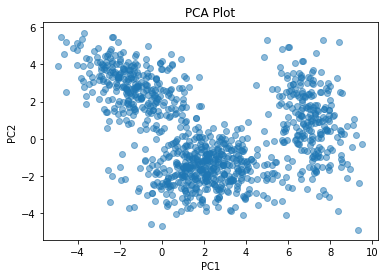

In [22]:
# plot projected data
plt.title('PCA Plot') 
plt.xlabel('PC1') 
plt.ylabel('PC2') 
plt.scatter(X_projected[:,0],X_projected[:,1],alpha=.5)
plt.show()

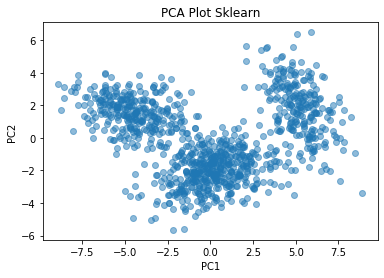

In [23]:
# compare my pca plot with sklearn plot
X_projected_sk = PCA(n_components=2).fit_transform(X)
plt.title('PCA Plot Sklearn') 
plt.xlabel('PC1') 
plt.ylabel('PC2') 
plt.scatter(X_projected_sk[:,0],X_projected_sk[:,1],alpha=.5)
plt.show()

In [24]:
# probability of generation of x from Gaussian distribution with mean_vect, cov_mat
# P(x | mean_vec,cov_mat)
def gaussian_prob(x,mean_vec,cov_mat):
    D = len(x)
    det_cov = np.linalg.det(cov_mat)
    x_minus_mu = x - mean_vec
    inv_cov = np.linalg.inv(cov_mat)
    z_score = (-1/2) * np.dot(np.dot(x_minus_mu,inv_cov), # 1xD . DxD = 1xD
                              x_minus_mu.T)               # 1xD . Dx1 = 1x1
    return np.exp(z_score) * ((2 * np.pi)**D * det_cov )**(-1/2)

In [25]:
def log_likelihood(X,means,covs,w):
    """Calculate
    ln p(X|μ,Σ,w) = \sum_{i=1}^{N} ln p(x_i|μ,Σ,w)
                  = \sum_{i=1}^{N} ln \sum_{k=1}^{K} w_k N(x_i|μ_k,Σ_k) 
    """
    sum_ln = 0
    for x in X:
        sum_wN = 0
        for k in range(len(means)):
            sum_wN += ( w[k] * gaussian_prob(x,means[k],covs[k]) )
        sum_ln += np.log(sum_wN)
    return sum_ln 

In [26]:
# EM Algorithm
def em_algorithm(X,n_cluster=3,max_iter=1000,eps=1e-4):
    n_data = len(X)
    # initial mean = choose k random data point as mean
    indices = np.random.choice(range(n_data),n_cluster,replace=False)
    means = X[indices]
    
    # initial covs = cov of the data
    cov_X = np.cov(X.T)
    covs = np.array([cov_X for _ in range(n_cluster)])

    # initial weight = 1/k
    w = np.array([1/n_cluster for _ in range(n_cluster)])

    # initial log likelihood
    likelihood = log_likelihood(X,means,covs,w)
    for _ in range(max_iter):
        # -------------E Step-------------
        p = np.zeros((n_data,n_cluster))
        for i in range(n_data):
            for k in range(n_cluster):
                p[i,k] = w[k] * gaussian_prob(X[i],means[k],covs[k])
            # normalize
            p[i] /= np.sum(p[i])

        # -------------M Step-------------
        for k in range(n_cluster):
            # adjust mean
            new_mean = np.zeros_like(means[k])
            sum_p_ik = 0
            for i in range(n_data):
                new_mean += p[i,k] * X[i]
                sum_p_ik += p[i,k]
            means[k] = new_mean/sum_p_ik

            # adjust cov
            new_cov = np.zeros_like(covs[k])
            for i in range(n_data):
                x_minus_mu = X[i] - means[k]
                new_cov += p[i,k] * np.outer(x_minus_mu,x_minus_mu)
                # np.dot(x.T,x) -> dot product, not (dx1)*(1xd) = (dxd) matrix
                # np.outer(x,x) -> gives      ,     (dx1)*(1xd) = (dxd) matrix
            covs[k] = new_cov/sum_p_ik

            # adjust w
            new_w = np.zeros_like(w[k])
            for i in range(n_data):
                new_w += p[i,k]
            w[k] = new_w/n_data

        # -------------Evaluation-------------
        likelihood_new = log_likelihood(X,means,covs,w)
        relative_diff  = np.abs((likelihood_new - likelihood)/likelihood) 
        if relative_diff < eps: break
        likelihood = likelihood_new
    return (means, covs, w, p)

In [27]:
# get means, covs, w from EM Algorithm
n_cluster = 3
means, covs, w, p = em_algorithm(X_projected,n_cluster)

In [28]:
# print means, covs, w for report
print(repr(means))
print(repr(covs))
print(repr(w))

array([[ 7.07834505,  0.99001032],
       [-1.29955099,  2.78647633],
       [ 2.10536814, -1.63801982]])
array([[[ 0.82749296, -0.57703332],
        [-0.57703332,  3.36210216]],

       [[ 2.00335707, -0.88446569],
        [-0.88446569,  1.48055944]],

       [[ 2.52505375,  0.16758291],
        [ 0.16758291,  1.08819746]]])
array([0.24042078, 0.30326928, 0.45630994])


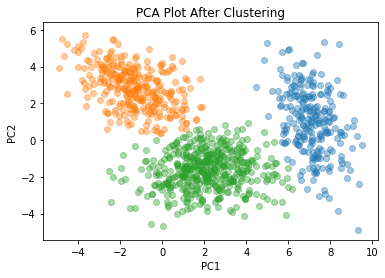

In [29]:
# seperate cluster and plot with various color
clusters = [ [] for _ in range(n_cluster) ]

for i,point in enumerate(X_projected):
    cluster_index = np.argmax(p[i])
    clusters[cluster_index].append(point)

plt.title('PCA Plot After Clustering') 
plt.xlabel('PC1') 
plt.ylabel('PC2') 
for cluster in clusters:
    cluster = np.array(cluster)
    plt.scatter(cluster[:,0],cluster[:,1],alpha=.4)
plt.show()

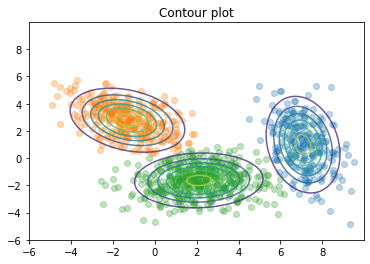

In [33]:
# this is not my code: copied from internet to plot contour
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                     mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

def plot_contours(clusters, means, covs, title):
    plt.figure()
    for cluster in clusters:
        cluster = np.array(cluster)
        plt.scatter(cluster[:,0],cluster[:,1],alpha=.3)
    delta = 0.025
    k = len(means)
    x = np.arange(-6.0, 10.0, delta)
    y = np.arange(-6.0, 10.0, delta)
    X, Y = np.meshgrid(x, y)
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, alpha=.8)
    plt.title(title)
plot_contours(clusters, means, covs,"Contour plot")